# Computer Vision Assignment: Face Recognizer
## Import necessary libs and datasets

Let me show 40 different people.
images shape: (400, 64, 64), labels shape: (400,)


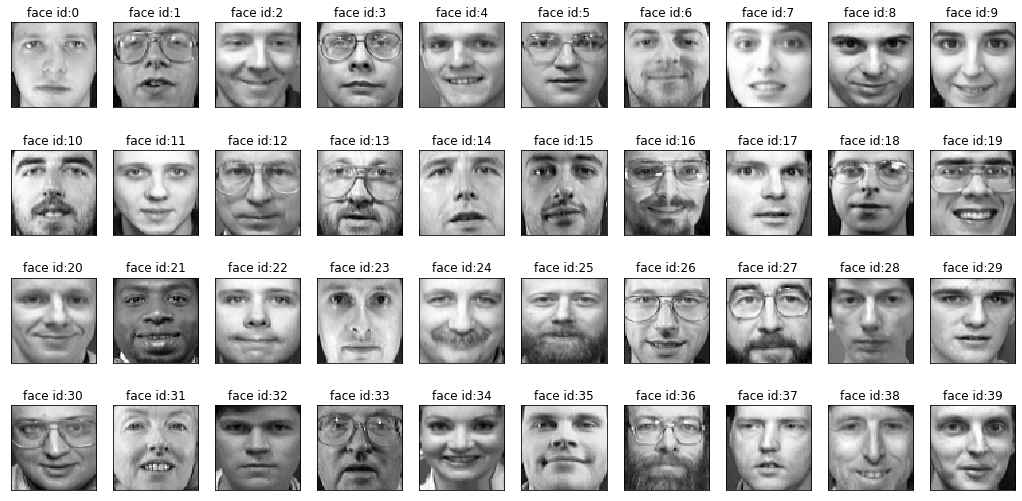

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

%matplotlib inline

olivetti = fetch_olivetti_faces()
images = olivetti.images
labels = olivetti.target

def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
        
print(f"Let me show {len(np.unique(labels))} different people.")
show_40_distinct_people(images, np.unique(labels))

print(f"images shape: {images.shape}, labels shape: {labels.shape}")

https://wikidocs.net/49847 올리베티 얼굴 데이터셋에 대한 정보는 여기서!


 x: 400 행 4096 열 (40명의 흑백 얼굴 사진 400장, 4096 (64x64) 특성)
 
0.0 ~ 1.0 (0~255 를 스케일링)

 y:400 행
 
0~39 (40명)

## train, test split
### 평가에 사용할 예정이니 트레인, 테스트 스플릿 코드는 그대로 유지시켜주세요

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=0,
                                                   stratify=labels, test_size=0.1)

print(len(X_train), len(X_test))

360 40


In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(360, 64, 64)
(360,)
(40, 64, 64)
(40,)


## training
### Data Augmentation
#### 뉴럴 네트워크를 훈련시키는데 360개의 인스턴스는 턱없이 부족합니다. 
#### 따라서 `torchvision`의 `transforms`를 이용해서 data augmentation을 해주세요.

In [4]:
import torch
from torch import nn, optim

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage
import PIL


In [5]:
import torchvision
from torchvision import transforms

[data augmentation 참고 링크(1)](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/) <br> 

#### ***우선 torchvision의 transformation을 이용한 방법이 아닌 링크의 augmentation 방식을 따라해봤습니다.***

In [7]:
final_train_data = []
final_target_train = []
for i in tqdm(range(X_train.shape[0])):
    final_train_data.append(X_train[i])
    final_train_data.append(rotate(X_train[i], angle=45, mode = 'wrap'))
    final_train_data.append(np.fliplr(X_train[i]))
    final_train_data.append(np.flipud(X_train[i]))
    final_train_data.append(random_noise(X_train[i],var=0.2**2))
    for j in range(5):
        final_target_train.append(y_train[i])

100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:00<00:00, 580.27it/s]


In [8]:
len(final_target_train), len(final_train_data)
final_train = np.array(final_train_data)
final_target_train = np.array(final_target_train)

In [9]:
print(final_train.shape)
print(final_target_train.shape)

(1800, 64, 64)
(1800,)


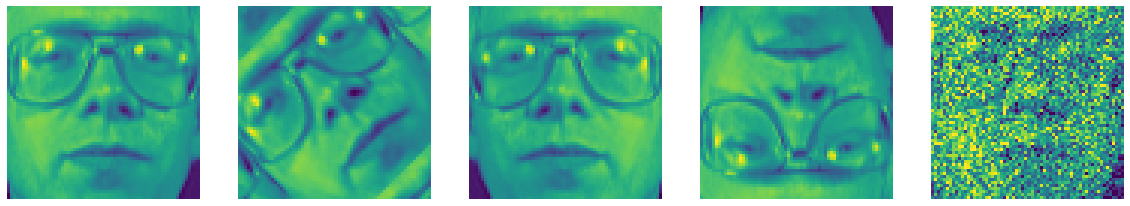

In [10]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(final_train[i+30])
    ax[i].axis('off')

####  `torchvision`의 `transforms`를 이용해서 data augmentation을 해주세요.

[data augmentation 참고 링크(1)](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/) <br>
[data augmentation 참고 링크(2)](https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll)

In [11]:
import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

compose = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomVerticalFlip(p=0.5),
    #torchvision.transforms.ColorJitter(hue=.05, saturation=.05), #얘때문에 알수없는 오류가 생겨서 얘는 빼고, 회전 및 뒤집기만 사용
    transforms.RandomHorizontalFlip(), #이미지 수평으로 뒤집기. 글자아니라 이미지 데이터니까 써도 될듯?
    transforms.RandomRotation(20),#이미지 해당 각도로 회전
    transforms.ToTensor()
])

http://incredible.ai/pytorch/2020/04/25/Pytorch-Image-Augmentation/ 

#### `이 외에도 여러가지 방법으로 augmentation 가능`

transforms.ToPILImage() - csv 파일로 데이터셋을 받을 경우, PIL image로 바꿔준다.  
transforms.CenterCrop(size) - 가운데 부분을 size 크기로 자른다.  
transforms.Grayscale(num_output_channels=1) - grayscale로 변환한다.  
transforms.RandomAffine(degrees) - 랜덤으로 affine 변형을 한다.  
transforms.RandomCrop(size) -이미지를 랜덤으로 아무데나 잘라 size 크기로 출력한다.  
transforms.RandomResizedCrop(size) - 이미지 사이즈를 size로 변경한다  
transforms.Resize(size) - 이미지 사이즈를 size로 변경한다  
transforms.RandomRotation(degrees) 이미지를 랜덤으로 degrees 각도로 회전한다.  
transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)) - 이미지를 랜덤으로 변형한다.  
transforms.RandomVerticalFlip(p=0.5) - 이미지를 랜덤으로 수직으로 뒤집는다. p =0이면 뒤집지 않는다.  
transforms.RandomHorizontalFlip(p=0.5) - 이미지를 랜덤으로 수평으로 뒤집는다.  
                                              * 글자 이미지를 데이터에 넣을 경우, 뒤집기 설정은 넣지 않는 것이 좋을듯?         
transforms.ToTensor() - 이미지 데이터를 tensor로 바꿔준다.  
transforms.Normalize(mean, std, inplace=False) - 이미지를 정규화한다.

### 함수의 빈칸을 채워가면서 FaceDataset, FaceClassifier를 만들어주세요.

In [13]:
class FaceDataset(Dataset):
    
    #데이터셋을 가져와서 선처리
    def __init__ (self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    #데이터셋에서 한개의 데이터를 가져오는 함수를 정의
    def __getitem__(self,idx):
        label = self.labels[idx]
        image = self.images[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return [image, label]
    
    #데이터셋의 길이를 반환. 이상하게 넣으면 오류가난다
    #def __len__(self):
    #    return self.len

### 적절한 parameter를 사용해서 dataset과 train에 쓸 DataLoader를 만들어주세요.
### FaceDataset, DataLoader 생성자에 들어갈 parameter는 적당히 넣어주세요.

In [14]:
dataset1 = FaceDataset(X_train, y_train, transform=compose) 
dataset2 = FaceDataset(X_train, y_train, transform=compose) 
dataset3 = FaceDataset(X_train, y_train, transform=compose) 
dataset4 = FaceDataset(X_train, y_train, transform=compose) 
dataset5 = FaceDataset(X_train, y_train, transform=compose) 

In [15]:
#train set에 compose로 augmentation한 데이터 붙여주기
for i in range(360):
    X_train = np.append(X_train, dataset1[i][0], axis=0)
    y_train = np.append(y_train, dataset1[i][1])

..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [16]:
X_train.shape 

(720, 64, 64)

In [17]:
for i in range(360):
    X_train = np.append(X_train, dataset2[i][0], axis=0)
    y_train = np.append(y_train, dataset2[i][1])
    
for i in range(360):
    X_train = np.append(X_train, dataset3[i][0], axis=0)
    y_train = np.append(y_train, dataset3[i][1])
    
for i in range(360):
    X_train = np.append(X_train, dataset4[i][0], axis=0)
    y_train = np.append(y_train, dataset4[i][1])

for i in range(360):
    X_train = np.append(X_train, dataset5[i][0], axis=0)
    y_train = np.append(y_train, dataset5[i][1])

In [18]:
X_train.shape 

(2160, 64, 64)

In [20]:
from torch.utils.data import TensorDataset 
#TensorDataset: Dataset을 상속한 클래스로 학습 데이터 X와 레이블 Y를 묶어 놓은 컨테이너 입니다.
X_train=X_train.reshape(2160,1,64,64)
X_train=torch.from_numpy(X_train)
y_train=torch.from_numpy(y_train)
train_data = TensorDataset(X_train,y_train) #X_train과 y_train 묶어주기

In [21]:
train_loader = DataLoader(dataset=train_data,
                          batch_size=32, 
                          shuffle=True,
                          num_workers=0) 

In [22]:
X_test=X_test.reshape(40,1,64,64)
X_test=torch.from_numpy(X_test)
y_test=torch.from_numpy(y_test)
test_data = TensorDataset(X_test,y_test) #X_train과 y_train 묶어주기

In [24]:
test_loader = DataLoader(dataset=train_data,
                          batch_size=8, 
                          shuffle=True,
                          num_workers=0)

### 360+$\alpha$개의 훈련 인스턴스를 사용해서 train 함수를 통해 training을 해주시고,
### eval 함수를 통해 40개의 test example에 대해서 accuracy를 측정해주세요.
### 함수 및 클래스 signature와 내부 코드는 적절히 알아서 짜주시면 됩니다.

##### Basic CNN사용
: 여름방학 3주차에서 숙제로 냈던 CNN코드를 활용

In [25]:
#GPU 사용설정+ random value 위한 seed 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [67]:
# 학습에 사용되는 parameters설정
#첫 시도에서는 learning_rate=0.01로 했더니 결과가 많이 좋지 않았습니다.... -->learning rate 더 줄여서 정확도 높이기
learning_rate=0.001
training_epochs=20
batch_size=32

In [68]:
class CNN(torch.nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.keep_prob = 0.5

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding=1),
            # (64-3+2)/1+1= 64 x 64
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
            # (64-2)/2+1= 32 x 32
        
    
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding=1),
            # (32-3+2)/1+1= 32 x 32
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
            # (32-2)/2+1= 16 x 16

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding=1),
            # (16-3+2)/1+1 = 16 x 16
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1))
            # (16-2+2)/2+1 = 9 x 9

        
        self.fc1 = torch.nn.Linear(10368, 1000 ,bias = True) #10368=128*9*9
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p = 1 - self.keep_prob))
            
        self.fc2 = torch.nn.Linear(1000, 40 ,bias = True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
    
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [69]:
model = CNN().to(device)

In [70]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [71]:
#모델 학습
total_batch = len(train_loader)

print('Learning started. It takes sometime')

for epoch in range(training_epochs):
    avg_cost = 0
    
    for X, Y in train_loader:
        X = X.reshape(-1,1,64,64)
        Y= Y.long()
        
        optimizer.zero_grad() 
        hypothesis = model(X)
        
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
        
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!!')

Learning started. It takes sometime
[Epoch:    1] cost = 3.60491157
[Epoch:    2] cost = 2.72717714
[Epoch:    3] cost = 1.72628546
[Epoch:    4] cost = 0.872211099
[Epoch:    5] cost = 0.445158809
[Epoch:    6] cost = 0.280927509
[Epoch:    7] cost = 0.221900925
[Epoch:    8] cost = 0.145511851
[Epoch:    9] cost = 0.120569535
[Epoch:   10] cost = 0.0942992344
[Epoch:   11] cost = 0.106844425
[Epoch:   12] cost = 0.0760367885
[Epoch:   13] cost = 0.0414788872
[Epoch:   14] cost = 0.0799189657
[Epoch:   15] cost = 0.0523090772
[Epoch:   16] cost = 0.0408323184
[Epoch:   17] cost = 0.0594528057
[Epoch:   18] cost = 0.0793922618
[Epoch:   19] cost = 0.0548176914
[Epoch:   20] cost = 0.0854424611
Learning Finished!!


In [72]:
#모델 성능 확인
with torch.no_grad():
    model.eval()
    
    X_test = X_test.reshape(-1,1,64,64)
    Y_test = y_test
    
    prediction = model(X_test) 
    correct_prediction = torch.argmax(prediction,1)== Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy: ', accuracy.item())

Accuracy:  0.9750000238418579
